# TRADE OFF BIAS - VARIANCE

## 1. Import libraries

In [1]:
# Basic
import numpy as np
import pandas as pd

# Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Plotting
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Generating data

### 2.1. Generate feature data

We set the Random Seed to ensure Ensure reproducibility of the random processes in the simulation by fixing the seed for the random number generator.

In [2]:
# Set seed for random samples
np.random.seed(2024)

Then we create an array `X` with 201 evenly spaced values between 0 and 20.

In [3]:
# Generating 201 observations for X
X = np.arange(0, 20.1, 0.1)

### 2.2. Data Generation Model

We define a deterministic function of `X` that includes a linear term, `20*X`, and a non-linear term, `-90*sin(X)`, to simulate a real-world scenario. It is plotted to show the true underlying pattern without noise.

In [4]:
# Set the Data Generation Model DGM
dgm = 500 + 20*X - 90*np.sin(X)

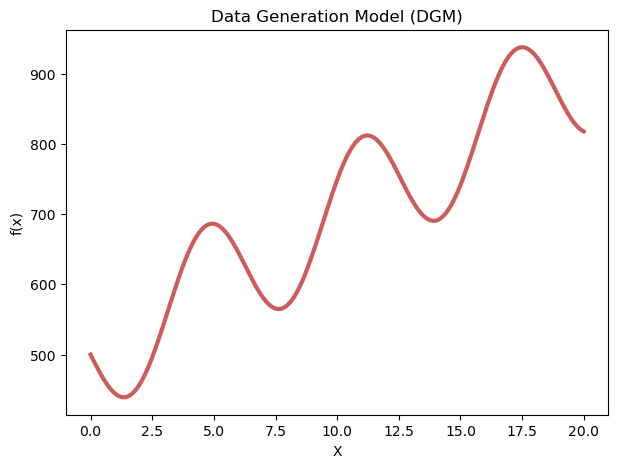

In [5]:
# Plot the Data Generation Model
plt.figure(figsize=(7, 5))
plt.plot(X, dgm, color='indianred', linewidth=3)
plt.title('Data Generation Model (DGM)')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.show()

### 2.3. Generating the output data

We Simulate real-world data by adding normally distributed noise to the DGM, creating the response variable `y`. This is also plotted to visualize how the actual observations may look.

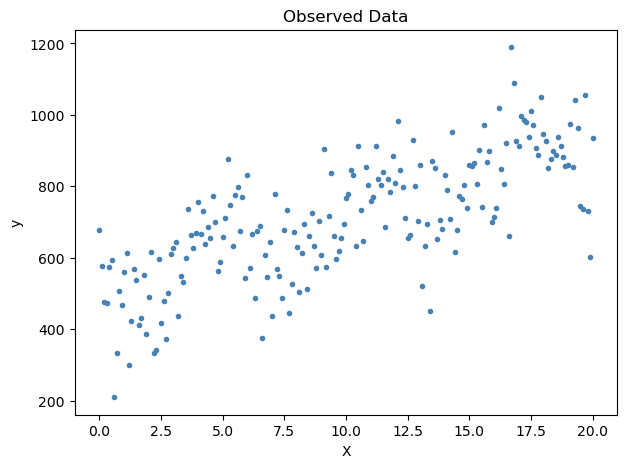

In [6]:
# Add some noise to data generation model
y = dgm + np.random.normal(10, 100, len(X))
plt.figure(figsize=(7, 5))
plt.plot(X, y, '.', color='steelblue')
plt.title('Observed Data')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### 2.4. Set as DataFrame

We sctructure the simulated feature `X`, the noise-free DGM, and the noisy observations `y` into a DataFrame for ease of manipulation.

In [7]:
# y and X in a data frame
data = pd.DataFrame({'dgm': dgm, 'y': y, 'X': X})
data.head(5)

,dgm,y,X
0,500.000000,676.804732,0.0
1,493.014993,576.749765,0.1
2,486.119760,475.965984,0.2
3,479.403181,474.311987,0.3
4,472.952349,574.557530,0.4


### 2.5. Training - Test Split

We Randomly select 80% of the data for training the model and reserves the remaining 20% for testing its performance.

In [8]:
tot_obs = data.shape[0]
idx = np.random.choice(tot_obs, size=int(0.8 * tot_obs), replace=False)
training_sample = data.iloc[idx]
testing_sample = data.drop(idx)

### 2.6. Plotting Observed Data vs. Data Generation Model (DGM)

We compare the observed data with the underlying Data Generation Model (DGM)

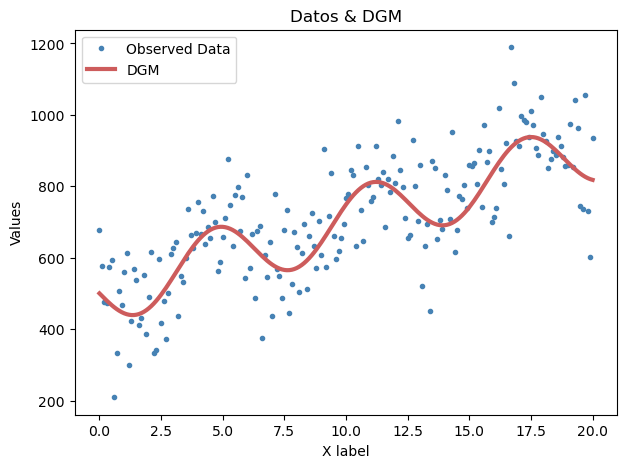

In [9]:
# Plotting the observed data and the Data Generation Model (DGM)
plt.figure(figsize=(7, 5))

# Plot observed data
plt.plot(X, y, '.', color='steelblue', label='Observed Data')

# Plot Data Generation Model (DGM)
plt.plot(X, dgm, color='indianred', linewidth=3, label='DGM')

# Additional plot settings
plt.title('Datos & DGM')
plt.xlabel('X label')
plt.ylabel('Values')
plt.legend()
plt.show()

## 3. Trade off Bias-Variance

Now, we will aim to estimate a model with the lowest possible error, measured using the RMSE (Root Mean Square Error) metric. To achieve this, we will implement three models with varying degrees of complexity: linear regression, polynomial regression, and spline regression.

### 3.1. Define and fit models

In [10]:
# 1) Linear Model
model1 = LinearRegression()
model1.fit(training_sample[['X']], training_sample['y'])

# 2) Polinomic model
poly_features = PolynomialFeatures(degree=12)
X_poly_train = poly_features.fit_transform(training_sample[['X']])
X_poly_test = poly_features.fit_transform(testing_sample[['X']])
model2 = LinearRegression()
model2.fit(X_poly_train, training_sample['y'])

# 3) Spline model
sorted_data = training_sample.sort_values(by='X')
X_sorted = sorted_data['X']
y_sorted = sorted_data['y']
model3 = UnivariateSpline(X_sorted, y_sorted, s=0, k=3)

### 3.2. Predict over training set and estimate the RSME

We obtain predictions and add those values to the DataFrame

In [11]:
predicted1 = model1.predict(training_sample[['X']])
predicted2 = model2.predict(X_poly_train)
predicted3 = model3(training_sample['X'])

training_sample_add = training_sample.copy(deep=True)
training_sample_add['linear_model_predict'] = predicted1
training_sample_add['polynomial_predict'] = predicted2
training_sample_add['spline_predict'] = predicted3

We define a function to estimate the RMSE

In [12]:
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

Then we estimate the RMSE and create and show results for the Training Set

In [13]:
rmse_linear = rmse(training_sample_add['y'], predicted1)
rmse_poly = rmse(training_sample_add['y'], predicted2)
rmse_spline = rmse(training_sample_add['y'], predicted3)

results = pd.DataFrame({
    "Models": ["Linear Model", "Polynomial Model", "Spline"],
    "RMSE": [rmse_linear, rmse_poly, rmse_spline]
})

results['RMSE'] = results['RMSE'].map('{:.15f}'.format)
results

,Models,RMSE
0,Linear Model,118.196309614417004
1,Polynomial Model,96.397886192494042
2,Spline,0.000000000000119


### 3.3. Linear Regression Model vs Data Generation Model (DGM)

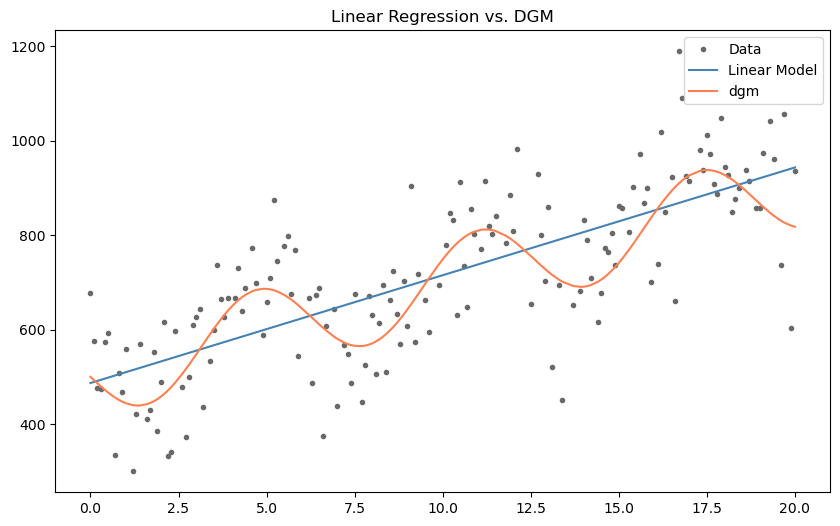

In [14]:
# Sort data
training_sample_reset = training_sample_add.reset_index()
sorted_indices = training_sample_reset['X'].argsort()
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
y_sorted = training_sample_reset.loc[sorted_indices, 'y']
dgm_sorted = training_sample_reset.loc[sorted_indices, 'dgm']
predicted1_sorted = predicted1[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted1_sorted, color='steelblue', label='Linear Model')
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Linear Regression vs. DGM')
plt.show()

### 3.4. Polynomic Model vs Data Generation Model (DGM)

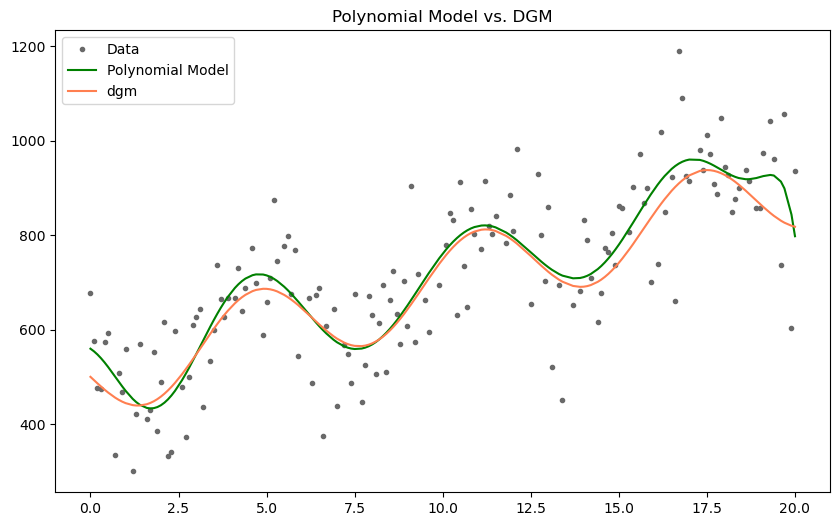

In [15]:
# Sort data
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
predicted2_sorted = predicted2[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted2_sorted, color='green', label='Polynomial Model')
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Polynomial Model vs. DGM')
plt.show()

### 3.4. Spline Model vs Data Generation Model (DGM)

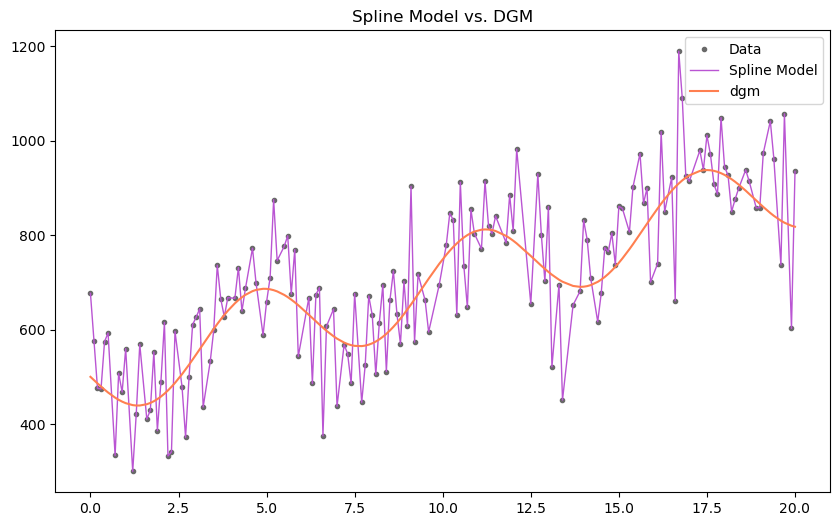

In [16]:
# Sort data
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
predicted3_sorted = model3(X_sorted)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted3_sorted, color='mediumorchid', label='Spline Model', linewidth=1)
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Spline Model vs. DGM')
plt.show()

### 3.5. Testing error

So far, we have predicted and calculated the error on the training set. Now, we will do the same with the test set.

In [17]:
# Predict over the test set
predicted1_test = model1.predict(testing_sample[['X']])
predicted2_test = model2.predict(X_poly_test)
predicted3_test = model3(testing_sample['X'])

# Estimate the RMSE for the test set
rmse_linear_test = rmse(testing_sample['y'], predicted1_test)
rmse_poly_test = rmse(testing_sample['y'], predicted2_test)
rmse_spline_test = rmse(testing_sample['y'], predicted3_test)

# Compute the RMSE for the test set
results_test = pd.DataFrame({
    "Models": ["Linear Model", "Polynomial Model", "Spline"],
    "RMSE": [rmse_linear_test, rmse_poly_test, rmse_spline_test]
})

results_test

,Models,RMSE
0,Linear Model,110.077497
1,Polynomial Model,119.891856
2,Spline,164.740102
